# DS-SF-23 Final Project
### [Predicting Airbnb bookings](https://docs.google.com/presentation/d/1FVTTS478OCozncuxhWlaJr5ZkUGrMPHfKJ6uLm4Hsuw/edit?usp=sharing)
Vanessa Grass, July 12th 2016

______________________________________________________________________________________________________________________

# Part 4 continued: Modeling Performance
Below is where I actually implement models. I learn that linear regression is definitely not appropriate for this dataset. After reworking first booking from number of days into binary (1 - first booking occurs same day as first active, 0 - first booking occurs 1+ days after first active), I try logistic regression, k nearest neighbors, and random forest. These result in slightly better score but still not great. Next steps to try are to go back to the data and try to normalize & transformation (perhaps log). After which I would further tune models & deep dive into cross validation. Other avenues would be to look into the additonal datasets provided by Airbnb as well as examinge other variables (ie age & gender) as my response variable.

## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import csv
import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import datasets, tree, feature_selection, linear_model, neighbors, ensemble, cross_validation, grid_search, metrics
from sklearn.externals.six import StringIO  

# pd.set_option('display.max_rows', 10)
# pd.set_option('display.notebook_repr_html', True)
# pd.set_option('display.max_columns', 999)

%matplotlib inline
plt.style.use('ggplot')

## Import Data 

In [2]:
users = pd.read_csv(os.path.join('datasets', 'airbnb_features.csv'))

In [3]:
users.head(2)

id  gender   age signup_method signup_flow language affiliate_channel  \
0   0  FEMALE  44.0      facebook        zero       en            direct   
1   1    MALE  47.0         basic        zero       en             other   

  affiliate_provider first_affiliate_tracked signup_app        ...          \
0             direct                  linked    not-iOS        ...           
1              other           tracked-other    not-iOS        ...           

  dest_ES dest_FR dest_GB  dest_IT dest_NL  dest_PT  dest_US  dest_other  \
0     0.0     0.0     0.0      0.0     0.0      0.0      1.0         0.0   
1     0.0     0.0     0.0      0.0     0.0      0.0      1.0         0.0   

   binary_dest_US  binary_dest_other  
0             1.0                0.0  
1             1.0                0.0  

[2 rows x 127 columns]

## Clean up new columns

#### Create new dataframe from variables that seem most promising as predictors

In [4]:
users = users[ ['days', 'age_b', 'Gender_MALE', 'signup_basic', 'lang_fr', 'lang_ja', 'lang_pt', 
                'affiliate_channel_direct','affiliate_provider_direct', 'affiliate_provider_google', 'aff_linked', 
                'aff_other', 'aff_omg', 'Mac_Desktop','Safari' ]]

#### Renaming a few columns...

In [5]:
users.rename(columns={
'age_b': 'age', 'Gender_MALE': 'gender','signup_basic': 'signup','lang_fr': 'french',
'lang_ja': 'japanese','lang_pt': 'portuguese','affiliate_channel_direct': 'direct_affiliate_channel', 
'affiliate_provider_direct': 'direct_affiliate_provider', 'affiliate_provider_google': 'google_affiliate_provider',
'aff_linked':'linked_affiliate', 'aff_other': 'other_affiliate', 'aff_omg': 'omg_affiliate'}, inplace = True)

In [6]:
users.head(2)

days  age  gender  signup  french  japanese  portuguese  \
0   3.0  1.0     0.0     0.0     0.0       0.0         0.0   
1   2.0  1.0     1.0     1.0     0.0       0.0         0.0   

   direct_affiliate_channel  direct_affiliate_provider  \
0                       1.0                        1.0   
1                       0.0                        0.0   

   google_affiliate_provider  linked_affiliate  other_affiliate  \
0                        0.0               1.0              0.0   
1                        1.0               0.0              1.0   

   omg_affiliate  Mac_Desktop  Safari  
0            0.0          1.0     1.0  
1            0.0          0.0     0.0

In [7]:
users.shape

(15470, 15)

#### Data dictionary (kinda)
1. days = booking date - first active date

2. age = 1.0 (18-29), 0.0 (30+)

3. gender = 1.0 (male), 0.0 (female)

4. signup = 1.0 (basic), 0.0 (facebook)

5. french = 1.0 (french), 0.0 (other language)

6. japanese = 1.0 (japanese), 0.0 (other language)

7. portuguese = 1.0 (portuguese), 0.0 (other language)

8. direct_affiliate_channel = 1.0 (direct), 0.0 (other affiliate)

9. direct_affiliate_provider = 1.0 (direct), 0.0 (other affiliate)

10. google_affiliate_provider = 1.0 (google), 0.0 (other affiliate)

11. linked_affiliate = 1.0 (linked), 0.0 (other)

12. other_affiliate = 1.0 (other), 0.0 (other)

13. omg_affiliate = 1.0 (omg), 0.0 (all non-other)

14. Mac_Desktop = 1.0 (Mac Desktop), 0.0 (other device)

15. Safari = 1.0 (Safari), 0.0 (other browser)

# Models

### Linear Regression
I already know there isn't really a linear relationship between any of the variables but I'm just curious

In [8]:
#I realize this is too many variables but trying the kitchen sink strategy
smf.ols(formula = 
'days ~ age + gender + signup + french + japanese + portuguese + direct_affiliate_channel + direct_affiliate_provider + google_affiliate_provider + linked_affiliate + other_affiliate + omg_affiliate + Mac_Desktop + Safari', 
data = users).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     18.99
Date:                Wed, 13 Jul 2016   Prob (F-statistic):           7.03e-45
Time:                        18:35:03   Log-Likelihood:                -86479.
No. Observations:               15470   AIC:                         1.730e+05
Df Residuals:                   15456   BIC:                         1.731e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                    27.5626      4.695      5.871      0.000        18.360    36.766
age                           5.9442      1.047      5.678      0.000         3.892     7.996
gender                       -5.6844      1.052     -5.401      0.000        -7.747    -3.621
signup                       -8.0096      1.079     -7.420      0.000       -10.125    -5.894
french                        9.6176      6.546      1.469      0.142        -3.213    22.448
japanese                    -30.0272     14.887     -2.017      0.044       -59.208    -0.847
portuguese                   37.0913     17.341      2.139      0.032         3.101    71.081
direct_affiliate_channel     -2.6634      1.013     -2.630      0.009        -4.648    -0.678
direct_affiliate_provider    -2.6634      1.013     -2.630      0.009        -4.648    -0.678
google_affiliate_provider    -9.8014      2.098     -4.672      0.000       -13.913    -5.690
linked_affiliate             11.8227      4.402      2.686      0.007         3.194    20.452
other_affiliate              21.4340      4.942      4.337      0.000        11.746    31.122
omg_affiliate                 9.1495      4.509      2.029      0.042         0.311    17.989
Mac_Desktop                   3.3886      1.254      2.703      0.007         0.931     5.846
Safari                        1.8300      1.425      1.285      0.199        -0.962     4.622
==============================================================================
Omnibus:                     9285.454   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70464.080
Skew:                           2.925   Prob(JB):                         0.00
Kurtosis:                      11.665   Cond. No.                     2.77e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.9e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [9]:
#as simple as I can make this
smf.ols(formula = 
'days ~ age + gender + signup + google_affiliate_provider + other_affiliate + Mac_Desktop', 
data = users).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     36.51
Date:                Wed, 13 Jul 2016   Prob (F-statistic):           3.50e-44
Time:                        18:35:07   Log-Likelihood:                -86493.
No. Observations:               15470   AIC:                         1.730e+05
Df Residuals:                   15463   BIC:                         1.731e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                    34.4460      1.365     25.238      0.000        31.771    37.121
age                           5.7369      1.045      5.488      0.000         3.688     7.786
gender                       -5.7212      1.052     -5.438      0.000        -7.783    -3.659
signup                       -8.4238      1.073     -7.852      0.000       -10.527    -6.321
google_affiliate_provider    -6.4815      1.060     -6.117      0.000        -8.559    -4.404
other_affiliate              12.7108      2.397      5.303      0.000         8.013    17.409
Mac_Desktop                   4.1397      1.049      3.945      0.000         2.083     6.196
==============================================================================
Omnibus:                     9299.749   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70664.913
Skew:                           2.931   Prob(JB):                         0.00
Kurtosis:                      11.676   Cond. No.                         7.29
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Plot Models

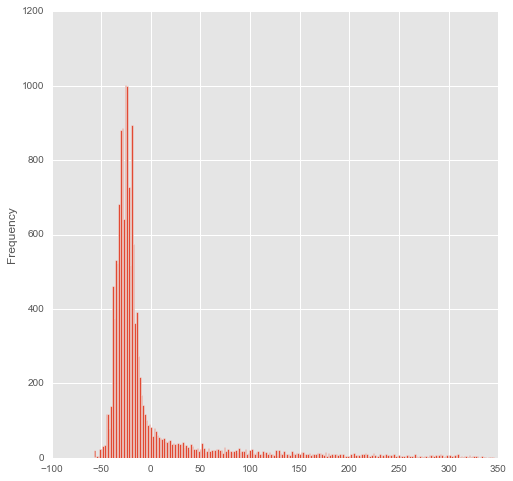

In [30]:
model = smf.ols(formula = 'days ~ age + gender + signup + google_affiliate_provider + other_affiliate + Mac_Desktop', data = users).fit()
model.resid.plot(kind = 'hist', bins = 250, figsize = (8, 8))

plt.show()

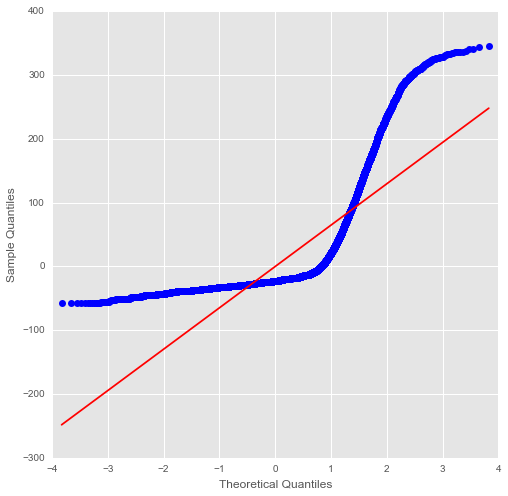

In [12]:
#q-q plot (residuals) against a normal distribution
figure, ax = plt.subplots(figsize = (8, 8))
figure = sm.qqplot(model.resid, line = 's', ax = ax)

plt.show()

### More appropriate models
I realize at about the half-way point that linear regression was not going to yield a good model. I can rework my hypothesis into a classification problem by instead predicting whether Airbnb users book the same day they are first active.

#### Converting days into categorical/binary data

In [10]:
#checking bookings that happen the same day the user is first active
sum(users.days == 0)

3889

In [11]:
#checking bookings that happen more than one day after the user is first active
sum(users.days > 0)

11581

In [12]:
#summing them up - looks right
3889+11581

15470

In [13]:
#reassiging any number other than 0 to 1, thus giving me binary data
users.days = np.where(users.days !=0, 1, 0)

In [14]:
users.days.value_counts()

1    11581
0     3889
Name: days, dtype: int64

In [15]:
#separate data into training and testing sets
train_users = users.sample(frac = .6, random_state = 0)
test_users = users.drop(train_users.index)

In [31]:
#model features

train_X = train_users[['age', 'gender', 'signup', 'google_affiliate_provider', 
                       'other_affiliate', 'Mac_Desktop']]
train_y = train_users.days

test_X = test_users[['age', 'gender', 'signup', 'google_affiliate_provider', 
                     'other_affiliate', 'Mac_Desktop']]
test_y = test_users.days

### Logistic Regression

In [17]:
model_users = linear_model.LogisticRegression()
model_users.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
#score based on training 
model_users.score(train_X, train_y)

0.25317819435466493

In [19]:
#score based on testing 
model_users.score(test_X, test_y)

0.24870717517776342

### K Nearest Neighbors

In [20]:
model_users = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'uniform')
model_users.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [24]:
cross_validation.cross_val_score(model_users, train_X, train_y, cv = 5)

array([ 0.19702233,  0.19783058,  0.22342148,  0.19378531,  0.2265808 ])

In [23]:
model_users.score(test_X, test_y)

0.21315449256625726

### Random Forest

In [25]:
model_users = ensemble.RandomForestClassifier(n_estimators = 5)
model_users.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
cross_validation.cross_val_score(model_users, train_X, train_y, cv = 10)

array([ 0.20106289,  0.2181987 ,  0.22888016,  0.23319328,  0.25770925,
        0.26297968,  0.26542491,  0.28023952,  0.28606357,  0.29625   ])

In [28]:
model_users.score(test_X, test_y)

0.24256625727213962